### Project on A/B testing by Mikhail Mussel

Hi, today I'll assume a role of an analyst at a big online store. Together with the marketing
department, I've compiled a list of hypotheses that may help boost
revenue.

I'll prioritize these hypotheses, launch an A/B test, and analyze the
results.

#### Description of the data

**Data used in the first part of the project**

*Hypotheses:*

- Hypotheses — brief descriptions of the hypotheses
- Reach — user reach, on a scale of one to ten
- Impact — impact on users, on a scale of one to ten
- Confidence — confidence in the hypothesis, on a scale of one to ten
- Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

**Data used in the second part of the project**

*Orders*

- transactionId — order identifier
- visitorId — identifier of the user who placed the order
- date — of the order
- revenue — from the order 
- group — the A/B test group that the user belongs to

*Visits*

- date — date
- group — A/B test group
- visits — the number of visits on the date specified in the A/B test group specified


#### Loading the data

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import math
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading datasets

try:
    orders = pd.read_csv('/datasets/orders_us.csv')
    visits = pd.read_csv('/datasets/visits_us.csv')
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
except:
    orders = pd.read_csv('orders_us.csv')
    visits = pd.read_csv('visits_us.csv')
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')

In [3]:
# fixing columns

pd.set_option('display.max_colwidth', None)
hypotheses.columns = hypotheses.columns.str.lower()
orders.columns = orders.columns.str.lower()
visits.columns = visits.columns.str.lower()

In [4]:
# looking at hypotheses

hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [5]:
# displaying orders

orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionid  1197 non-null   int64  
 1   visitorid      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [7]:
# displaying visits

visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


#### Preprocessing data

We don't have missing values in any of our dataframes but there's still are some potential issues and errors. 

In [9]:
# fixing datetypes 

orders['date']=pd.to_datetime(orders['date'],dayfirst=True)
visits['date']=pd.to_datetime(visits['date'],dayfirst=True)

In [10]:
# checking for errors in dates for orders

print(orders.date.min())
print()
print(orders.date.max())

2019-08-01 00:00:00

2019-08-31 00:00:00


In [11]:
# checking for errors in dates for visits

print(visits.date.min())
print()
print(visits.date.max())

2019-08-01 00:00:00

2019-08-31 00:00:00


In [12]:
# checking for negative values in orders

orders[orders.revenue < 0]

,transactionid,visitorid,date,revenue,group


In [13]:
# checking for negative values in visits

visits[visits.visits < 0]

,date,group,visits


In [14]:
# checking for users in both groups

users_in_both_groups = orders.groupby('visitorid')['group'].apply(set).reset_index()
users_in_both_groups = users_in_both_groups[users_in_both_groups['group'].apply(len) > 1]
users_in_both_groups

,visitorid,group
2,8300375,"{B, A}"
44,199603092,"{B, A}"
51,232979603,"{B, A}"
55,237748145,"{B, A}"
66,276558944,"{B, A}"
84,351125977,"{B, A}"
97,393266494,"{B, A}"
114,457167155,"{B, A}"
119,471551937,"{B, A}"
122,477780734,"{B, A}"


In [15]:
# dropping duplicated rows

orders_clean = orders.drop_duplicates(subset='visitorid', keep=False)

In [16]:
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 937 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  937 non-null    int64         
 1   visitorid      937 non-null    int64         
 2   date           937 non-null    datetime64[ns]
 3   revenue        937 non-null    float64       
 4   group          937 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 43.9+ KB


#### Prioritizing Hypotheses

We'll start with ICE framework prioritizing and sorting our hypotheses in descending order to determine highest Impact, Confidence and Effort.

Then we'll do the same but with RICE framework and display that as well. 

To conclude this task we'll compare both results and analyze changes in prioritization in both methods.

In [17]:
# calculating ICE score

hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

# sorting hypotheses based on ICE score

ice_sorted = hypotheses.sort_values(by='ICE', ascending=False)
ice_sorted

,hypothesis,reach,impact,confidence,effort,ICE
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000


In [18]:
# calculating RICE score

hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

# sorting hypotheses based on RICE score

rice_sorted = hypotheses.sort_values(by='RICE', ascending=False)
rice_sorted

,hypothesis,reach,impact,confidence,effort,ICE,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0


Let's start off with observing the things of lowest importance that didn't change for both frameworks. We see that our bottom 4 hypotheses only traded places between each other. This shouldn't surprise us given the low scores. We can ignore those hypothses in our analysis for now.

Higher scores are a different story however since things shifted significantly  here. Top hypothesis in ICE is now least prioritized between top ones in RICE. That happened due to that hypothesis having low Reach score which is significant in RICE but not in ICE.

####  A/B Test Analysis

##### Graph cumulative revenue by group. Make conclusions and conjectures.

We can calculate the cumulative revenue on the whole dataframe and separate our groups with indexing.

In [19]:
# calculating cumulative sum

orders_clean['cumul_rev'] = orders_clean['revenue'].cumsum()
orders_clean.head()

,transactionid,visitorid,date,revenue,group,cumul_rev
0,3667963787,3312258926,2019-08-15,30.4,B,30.4
1,2804400009,3642806036,2019-08-15,15.2,B,45.6
3,3797467345,1196621759,2019-08-15,155.1,B,200.7
4,2282983706,2322279887,2019-08-15,40.5,B,241.2
5,182168103,935554773,2019-08-15,35.0,B,276.2


In [20]:
# separating groups

control_clean = orders_clean[orders_clean.group == 'A']
test_clean = orders_clean[orders_clean.group =='B']

In [21]:
# aggregating data on orders and visitors

datesGroups = orders_clean[['date','group']].drop_duplicates() 
ordersAggregated = datesGroups.apply(lambda x: orders_clean[np.logical_and(orders_clean['date'] <= x['date'], orders_clean['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}), axis=1).sort_values(by=['date', 'group'])

In [22]:
# merging and renaming

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

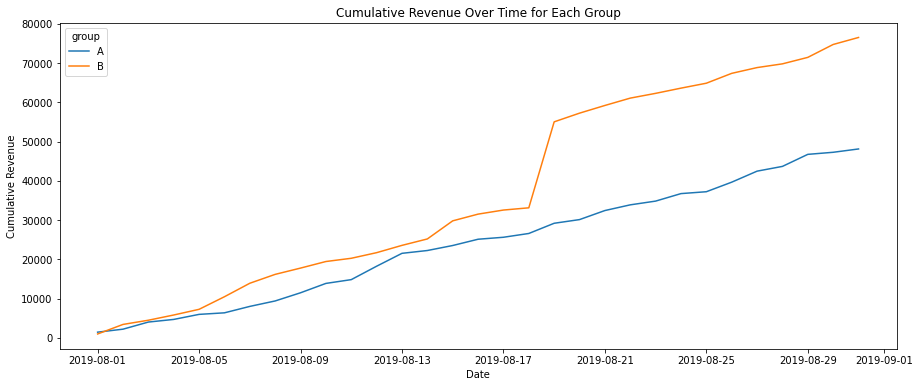

In [23]:
# visualizing cumulative revenue over time

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='revenue', hue='group', data=cumulativeData)
plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.title('Cumulative Revenue Over Time for Each Group')

plt.show()

We see from this graph that the Test group pulls ahead from the Control group almost immediately but keeps close up until 17th from which point group B shoots way up in a straight line which is quite unnatural.   

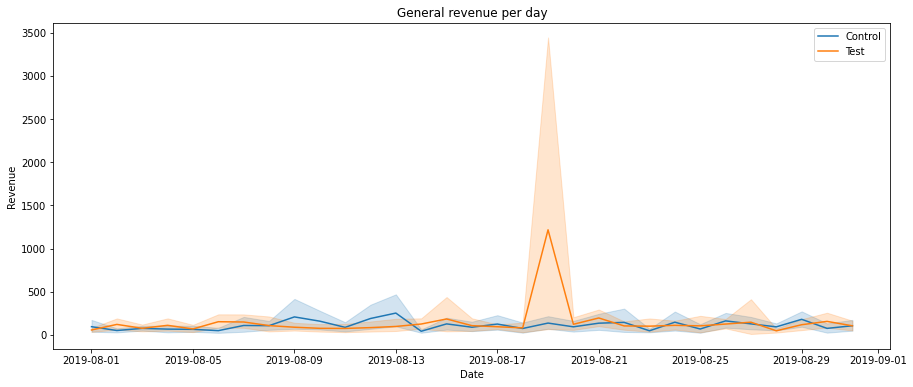

In [24]:
# visualizing general revenue per day

plt.rcParams["figure.figsize"] = (15,6)

sns.lineplot(x='date', y='revenue', data=control_clean, label='Control')
sns.lineplot(x='date', y='revenue', data=test_clean, label='Test')

plt.title('General revenue per day')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

Seems like we had a massive revenue increase in a certain time period, let's investigate further.

In [25]:
orders_clean[orders_clean.revenue > 1000].sort_values('date')

,transactionid,visitorid,date,revenue,group,cumul_rev
743,3603576309,4133034833,2019-08-09,1050.0,A,81065.0
1099,316924019,148427295,2019-08-12,1015.9,A,112397.3
1103,1348774318,1164614297,2019-08-12,1025.8,A,113438.3
1136,666610489,1307669133,2019-08-13,1425.8,A,118052.0
1196,3936777065,2108080724,2019-08-15,3120.1,B,124666.0
425,590470918,1920142716,2019-08-19,19920.4,B,50390.2
744,3668308183,888512513,2019-08-27,1335.6,B,82400.6


We have only a  handful of values greater than 1000 for the revenue column which makes the 20k that much of a sore thumb. 

Right now it seems like an outlier in our data.

#### Graph cumulative average order size by group. Make conclusions and conjectures.

Order size is a great metric to help us identify good marketing startegy. 

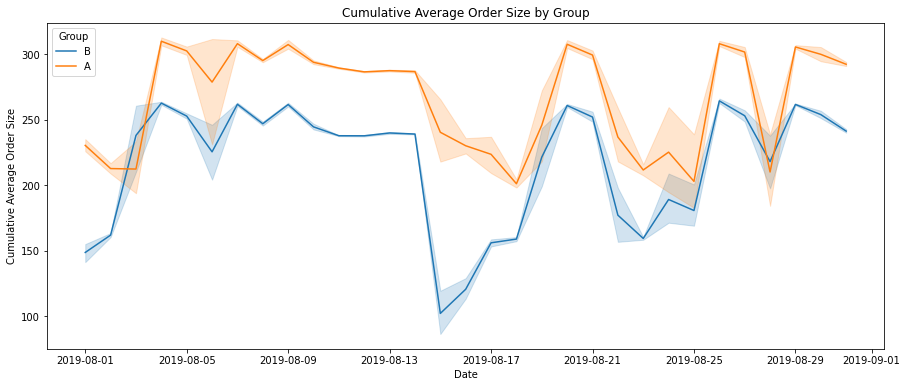

In [26]:
# visualizing cumulative order size per group

grouped_orders = orders_clean.groupby('group')

orders_clean['cumul_orders'] = grouped_orders.cumcount() + 1
orders_clean['cumul_avg_order_size'] = orders_clean['cumul_rev'] / orders_clean['cumul_orders']

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='cumul_avg_order_size', hue='group', data=orders_clean)

plt.xlabel('Date')
plt.ylabel('Cumulative Average Order Size')
plt.title('Cumulative Average Order Size by Group')
plt.legend(title='Group')
plt.show()

It's important to keep in mind that group A is the Control group and group B is the Test group. 

All things considered the Control group's behavior is pretty normal while the Test group experienced a dramatic spike downward mid month approximately after 13th. It did climb back up to the Control group result in the end though.

#### Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

To plot the relative difference in cumulative average order size for Group B compared with Group A, we can calculate the difference in cumulative average order size between the two groups for each day and then plot this difference over time.

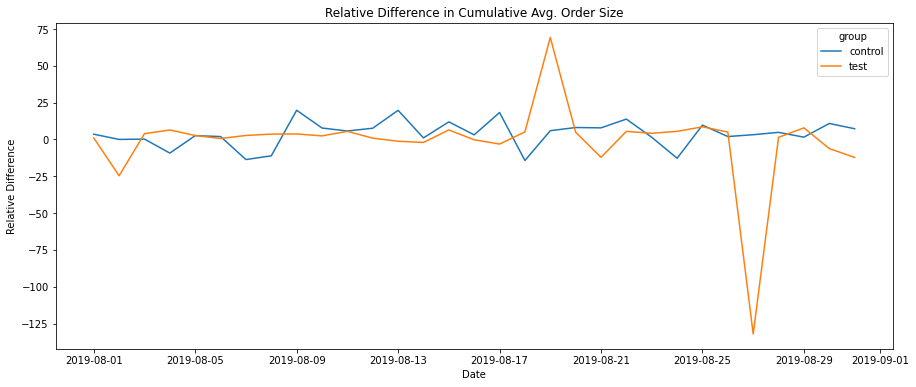

In [27]:
# calculating cumulative average order size for control group

control_clean['cumul_avg_order_size'] = control_clean.groupby('date')['revenue'].cumsum() / (control_clean.groupby('date').cumcount() + 1)
control_clean['relative_difference'] = control_clean.groupby('date')['cumul_avg_order_size'].diff()

# calculating cumulative average order size for test group

test_clean['cumul_avg_order_size'] = test_clean.groupby('date')['revenue'].cumsum() / (test_clean.groupby('date').cumcount() + 1)
test_clean['relative_difference'] = test_clean.groupby('date')['cumul_avg_order_size'].diff()

# combining the results for plotting

combined_df = pd.concat([control_clean.assign(group='control'), test_clean.assign(group='test')])

# plotting the relative difference

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='relative_difference', hue='group', data=combined_df, ci=None)
plt.xlabel('Date')
plt.ylabel('Relative Difference')
plt.title('Relative Difference in Cumulative Avg. Order Size')
plt.show()

We can see that both groups are fairly stable for the first half of the month but things do change after 17th where our test group sees a jump in cumulative average size but goes back right away. At the end of the month we can also see a huge drop for the test group. It's really quite noticable though it's abrupt. 

#### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures

In [28]:
# calculating clicks

clicks = visits.groupby(['date', 'group'])['visits'].sum().reset_index()
clicks.rename(columns={'visits': 'clicks'}, inplace=True)

# calculating the number of orders per day and group

buyers = orders.groupby(['date', 'group'])['transactionid'].nunique().reset_index()
buyers.rename(columns={'transactionid': 'buyers'}, inplace=True)

# merging the 'clicks' and 'buyers' DataFrames

conversion_data = pd.merge(clicks, buyers, on=['date', 'group'], how='outer').fillna(0)

# calculating conversion rate as the ratio of orders to unique visitors

conversion_data['conversion'] = conversion_data['buyers'] / conversion_data['clicks']
conversion_data.head()

,date,group,clicks,buyers,conversion
0,2019-08-01,A,719,24,0.033380
1,2019-08-01,B,713,21,0.029453
2,2019-08-02,A,619,20,0.032310
3,2019-08-02,B,581,24,0.041308
4,2019-08-03,A,507,24,0.047337


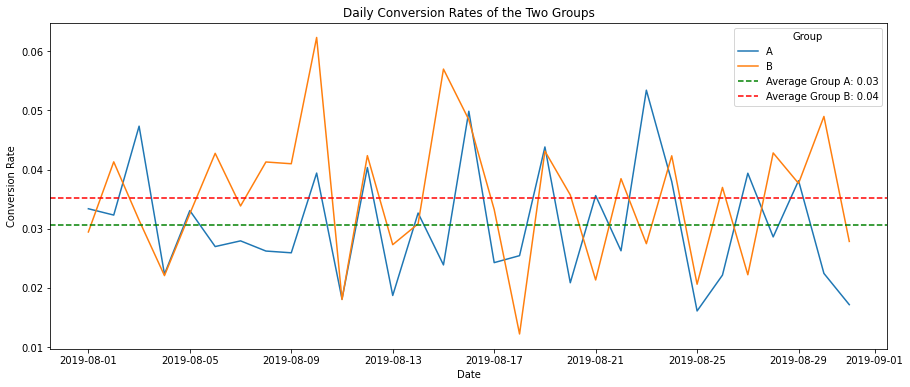

In [29]:
# visualizing daily conversion rates

avg_conversion_groupA = conversion_data[conversion_data['group'] == 'A']['conversion'].mean()
avg_conversion_groupB = conversion_data[conversion_data['group'] == 'B']['conversion'].mean()

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='conversion', hue='group', data=conversion_data)
plt.axhline(y=avg_conversion_groupA, color='green', linestyle='--', label=f'Average Group A: {avg_conversion_groupA:.2f}')
plt.axhline(y=avg_conversion_groupB, color='red', linestyle='--', label=f'Average Group B: {avg_conversion_groupB:.2f}')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.title('Daily Conversion Rates of the Two Groups')
plt.legend(title='Group')
plt.show()

As we can see on the draph above the conversion rates for both groups are not far apart from each other. I've added an average point for both groups to make note that the test group has slightly higher conversion rate than our control group. 

#### Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

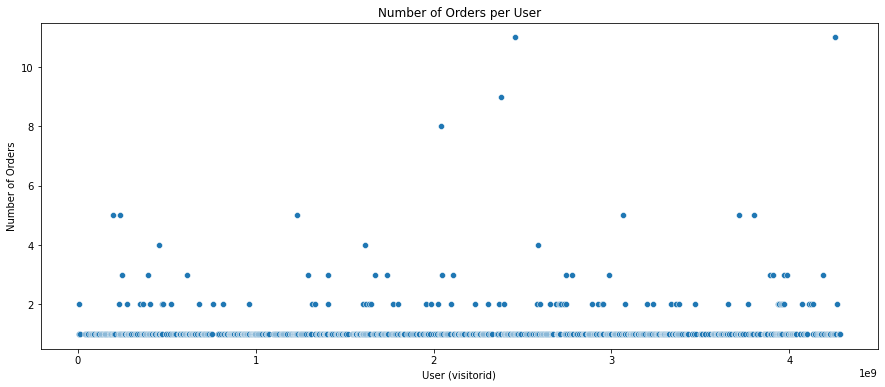

In [30]:
# calculating the number of orders per user

orders_per_user = orders.groupby('visitorid')['transactionid'].nunique().reset_index()
orders_per_user.columns = ['visitorid', 'orders_count']

# plotting a scatter chart of the number of orders per user

plt.figure(figsize=(15, 6))
sns.scatterplot(x='visitorid', y='orders_count', data=orders_per_user)
plt.xlabel('User (visitorid)')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per User')
plt.show()

It's clear that the absolute majority of our users only end up making a single order. And while we'd want our users to make more orders most people usually only purchase the things that they absolutely need and have searched for specifically and don't buy anything else.

#### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly

In [31]:
# grouping by visitors and counting the number of unique orders per user

orders_per_user = orders.groupby('visitorid')['transactionid'].nunique()

# calculating the 95th and 99th percentiles for the number of orders per user

percentiles_95th = np.percentile(orders_per_user, 95)
percentiles_99th = np.percentile(orders_per_user, 99)

print("95th percentile for the number of orders per user:", percentiles_95th)
print("99th percentile for the number of orders per user:", percentiles_99th)

95th percentile for the number of orders per user: 2.0
99th percentile for the number of orders per user: 4.0


In [32]:
orders_per_user.value_counts()

1     937
2      64
3      17
5       6
4       3
11      2
8       1
9       1
Name: transactionid, dtype: int64

My assumption as to at which point does the data point becomes an anomaly is at 8 orders per user simply because we have a gap between 5 orders and 8 which leads me to believe that those above are to be considered outliers.

#### Plot a scatter chart of order prices. Make conclusions and conjectures.


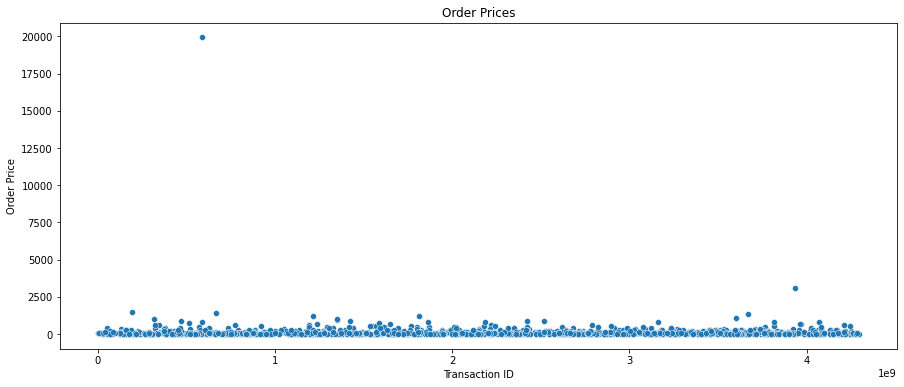

In [33]:
# plotting a scatter chart of order prices

plt.figure(figsize=(15, 6))
sns.scatterplot(x='transactionid', y='revenue', data=orders)
plt.xlabel('Transaction ID')
plt.ylabel('Order Price')
plt.title('Order Prices')
plt.show()

It's visibly clear that the vast majority of orders do not go over 2500$ with just a single order at 20k, which is quite absurd.

####  Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [34]:
percentile_95th = np.percentile(orders['revenue'], 95)
percentile_99th = np.percentile(orders['revenue'], 99)

print("95th percentile of order prices:", percentile_95th)
print("99th percentile of order prices:", percentile_99th)

95th percentile of order prices: 435.54
99th percentile of order prices: 900.9039999999999


In [35]:
orders_clean.revenue.describe()

count      937.000000
mean       133.048026
std        673.860340
min          5.000000
25%         20.700000
50%         50.100000
75%        125.900000
max      19920.400000
Name: revenue, dtype: float64

Clearly, the max value is where we can observe an anomaly. 

####  Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

###### Total conversion check

For greater depth we'll find our total conversion and average daily conversion.

To complete the first part of the task I'll define a function that will take number of clicks and purchases from both groups, find the p-value and compare it with the alpha value.

In [36]:
# creating a function to check the statistical significance

def check_hypothesis(successes1,trials1, successes2,trials2, alpha=0.05):
    
    # proportion for success in the first group
    p1 = successes1/trials1

   # proportion for success in the second group
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2
  
    print('p-value: ', p_value)
    if p_value<0.05:
        print('Reject H0')
    else:
        print('Failed To Reject H0')

Now I'll define the exact values for trials and successes in our data as well as fix any errors within it.

In [37]:
# we've been working with filtered data so far, this is our raw data

control_old = orders[orders.group=='A']
test_old = orders[orders.group=='B']

In [38]:
# calculating sum of revenue for control group

control_sum = control_old.groupby('date')['revenue'].sum().reset_index()
control_sum.rename(columns={'revenue': 'control_revenue'}, inplace=True)

# calculating sum of revenue for test group 

test_sum = test_old.groupby('date')['revenue'].sum().reset_index()
test_sum.rename(columns={'revenue': 'test_revenue'}, inplace=True)

# merging control and test sum of revenue DataFrames with conversion data 

conversion_data = pd.merge(conversion_data, control_sum, on='date', how='left')
conversion_data = pd.merge(conversion_data, test_sum, on='date', how='left')

# filling missing revenue values with 0

conversion_data['control_revenue'].fillna(0, inplace=True)
conversion_data['test_revenue'].fillna(0, inplace=True)

# calculating cumulative revenue for each day

conversion_data['cumul_rev'] = conversion_data['control_revenue'] + conversion_data['test_revenue']

# dropping redundant columns

conversion_data.drop(['control_revenue', 'test_revenue'], axis=1, inplace=True)
conversion_data.head()

,date,group,clicks,buyers,conversion,cumul_rev
0,2019-08-01,A,719,24,0.033380,3976.8
1,2019-08-01,B,713,21,0.029453,3976.8
2,2019-08-02,A,619,20,0.032310,4127.3
3,2019-08-02,B,581,24,0.041308,4127.3
4,2019-08-03,A,507,24,0.047337,3622.0


Now that we have our new dataframe we can split it by group. After that we can execute our function to find out the answer if there is a statistical significance of the difference in conversion between the groups.

In [39]:
# separating conversion data between the groups

conversion_control = conversion_data[conversion_data.group=='A']
conversion_test = conversion_data[conversion_data.group=='B']

In [40]:
# printing total clicks and conversions for control group

control_trials=conversion_control['clicks'].sum()
print("Trials:",control_trials)

control_successes=conversion_control['buyers'].sum()
print("Successes:",control_successes)

Trials: 18736
Successes: 557


In [41]:
# printing total clicks and conversions for test group

test_trials=conversion_test['clicks'].sum()
print("Trials:",test_trials)

test_successes=conversion_test['buyers'].sum()
print("Successes:",test_successes)

Trials: 18916
Successes: 640


In [42]:
# testing hypothesis

check_hypothesis(control_successes,control_trials, test_successes,test_trials, alpha=0.05)

p-value:  0.02320723394441848
Reject H0


We rejected our null hypothesis, the p-value is lower than the alpha value so we can say that there is statistical significance in conversion difference between the groups.

##### Average daily conversion

To archieve a broader picture we'll plot both conversions at the same time. This will help us to compare them.

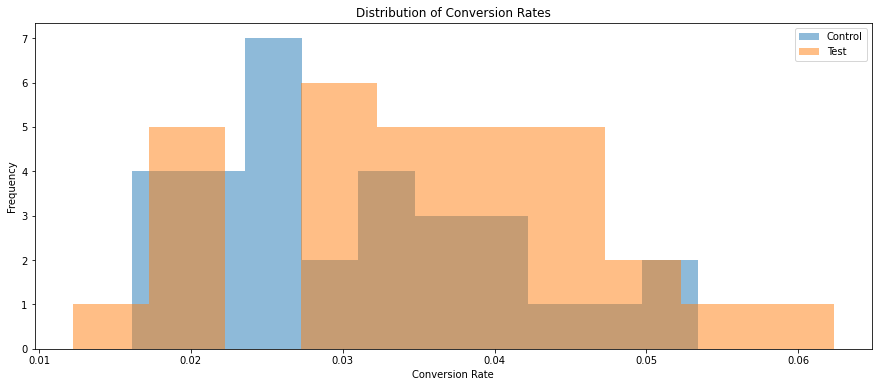

In [43]:
# plotting histograms for control and test groups

plt.hist(conversion_control['conversion'], alpha=0.5, label='Control')
plt.hist(conversion_test['conversion'], alpha=0.5, label='Test')

plt.legend(loc='upper right')
plt.title("Distribution of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Frequency")

plt.show()

There seems to be a lot more conversion in the Test group as we can see from this graph, the Control group is almost completely covered inside.

In [44]:
# creating a function to test normality

def testing_average(sample1,sample2,alpha=0.05):
    
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=stats.shapiro(sample1)
    stat2, p2_norm=stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    print(p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')

In [45]:
# testing hypothesis

testing_average(conversion_control['conversion'],conversion_test['conversion'],alpha=0.05)

0.0922947738393625
Fail to Reject H0


The function we created above and executed above was meant to compare means of two samples. It checks the normality of both samples with shapiro test. The null hypothesis of this test is that the data is normally distributed. 

Our result is that the p-value is greater than or equal to alpha, we failed to reject the null hypothesis and concluded that there is not enough evidence to suggest a significant difference between the means of the two samples.

#### Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

In [46]:
# creating an average check column

conversion_control['avg_ch']=conversion_control['cumul_rev']/conversion_control['buyers']
conversion_test['avg_ch']=conversion_test['cumul_rev']/conversion_test['buyers']

In [47]:
# printing mean value of average checks

print('Average check in group A:',conversion_control['avg_ch'].mean())
print('Average check in group B:',conversion_test['avg_ch'].mean())

Average check in group A: 285.7940636825247
Average check in group B: 250.50611737079598


In [48]:
# testing hypothesis

testing_average(conversion_control['avg_ch'],conversion_test['avg_ch'],alpha=0.05)

0.0980760730284865
Fail to Reject H0


We calculated an average order value for both groups on each day and then compared the mean values. Then we ran it through our function and concluded that there isn't a statistical significannce of the difference in average order size between the groups in raw data. 

#### Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures

After doing analysis on the raw data let's take a look at filtered data and compare the results we got at the end.

##### Total conversion

In [49]:
# calculating clicks

clicks = visits.groupby(['date', 'group'])['visits'].sum().reset_index()
clicks.rename(columns={'visits': 'clicks'}, inplace=True)

# calculating the number of orders per day and group

buyers = orders_clean.groupby(['date', 'group'])['transactionid'].nunique().reset_index()
buyers.rename(columns={'transactionid': 'buyers'}, inplace=True)

# merging the 'clicks' and 'buyers' DataFrames

conversion_data_new = pd.merge(clicks, buyers, on=['date', 'group'], how='outer').fillna(0)

# calculating conversion rate as the ratio of orders to unique visitors

conversion_data_new['conversion'] = conversion_data_new['buyers'] / conversion_data_new['clicks']
conversion_data_new.head()

,date,group,clicks,buyers,conversion
0,2019-08-01,A,719,15,0.020862
1,2019-08-01,B,713,17,0.023843
2,2019-08-02,A,619,15,0.024233
3,2019-08-02,B,581,20,0.034423
4,2019-08-03,A,507,24,0.047337


In [50]:
# calculating sum of revenue for control group

control_sum_new = control_clean.groupby('date')['revenue'].sum().reset_index()
control_sum_new.rename(columns={'revenue': 'control_revenue'}, inplace=True)

# calculating sum of revenue for test group 

test_sum_new = test_clean.groupby('date')['revenue'].sum().reset_index()
test_sum_new.rename(columns={'revenue': 'test_revenue'}, inplace=True)

# merging control and test sum of revenue DataFrames with conversion data 

conversion_data_new = pd.merge(conversion_data_new, control_sum_new, on='date', how='left')
conversion_data_new = pd.merge(conversion_data_new, test_sum_new, on='date', how='left')

# filling missing revenue values with 0

conversion_data_new['control_revenue'].fillna(0, inplace=True)
conversion_data_new['test_revenue'].fillna(0, inplace=True)

# calculating cumulative revenue for each day

conversion_data_new['cumul_rev'] = conversion_data_new['control_revenue'] + conversion_data_new['test_revenue']

# dropping redundant columns

conversion_data_new.drop(['control_revenue', 'test_revenue'], axis=1, inplace=True)
conversion_data_new.head()

,date,group,clicks,buyers,conversion,cumul_rev
0,2019-08-01,A,719,15,0.020862,2394.6
1,2019-08-01,B,713,17,0.023843,2394.6
2,2019-08-02,A,619,15,0.024233,3194.5
3,2019-08-02,B,581,20,0.034423,3194.5
4,2019-08-03,A,507,24,0.047337,2886.8


In [51]:
# separating conversion data between the groups

conversion_control_new = conversion_data_new[conversion_data_new.group=='A']
conversion_test_new = conversion_data_new[conversion_data_new.group=='B']

In [52]:
# printing total clicks and conversions for control group

control_trials_new = conversion_control_new['clicks'].sum()
print("Trials:",control_trials)

control_successes_new = conversion_control_new['buyers'].sum()
print("Successes:",control_successes)

Trials: 18736
Successes: 557


In [53]:
# printing total clicks and conversions for test group

test_trials_new = conversion_test_new['clicks'].sum()
print("Trials:",test_trials)

test_successes_new = conversion_test_new['buyers'].sum()
print("Successes:",test_successes)

Trials: 18916
Successes: 640


In [54]:
# testing hypothesis

check_hypothesis(control_successes_new,control_trials_new, test_successes_new,test_trials_new, alpha=0.05)

p-value:  0.009384750340914794
Reject H0


Same as with the raw data we have the results that tell us there is statistical significance of the difference in conversion between the groups, we rejected the null hypothesis in total conversion.

##### Average daily conversion

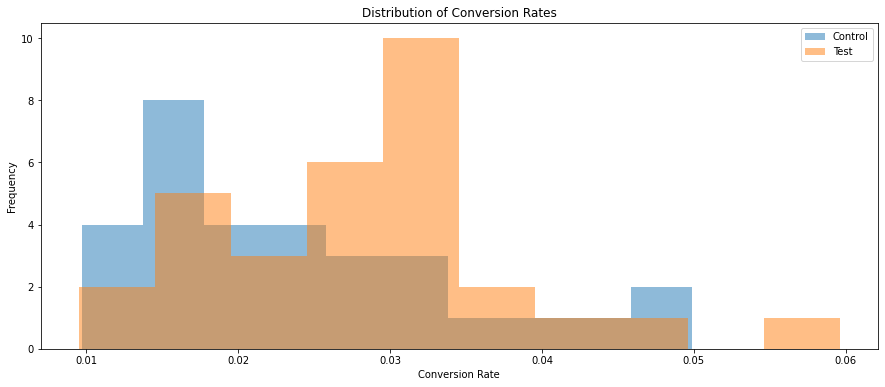

In [55]:
# plotting histograms for control and test groups

plt.hist(conversion_control_new['conversion'], alpha=0.5, label='Control')
plt.hist(conversion_test_new['conversion'], alpha=0.5, label='Test')

plt.legend(loc='upper right')
plt.title("Distribution of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Frequency")

plt.show()

It seems that the Test group has higher conversion rates than the Control group for the filtered data.

In [56]:
# testing hypothesis

testing_average(conversion_control_new['conversion'],conversion_test_new['conversion'],alpha=0.05)

0.05035667186320238
Fail to Reject H0


We also failed to reject the null hypothesis here same as with raw data in daily conversion.

#### Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

In [57]:
conversion_control_new['avg_ch']=conversion_control_new['cumul_rev']/conversion_control_new['buyers']
conversion_test_new['avg_ch']=conversion_test_new['cumul_rev']/conversion_test_new['buyers']

In [58]:
print('Average check in group A:',conversion_control_new['avg_ch'].mean())
print('Average check in group B:',conversion_test_new['avg_ch'].mean())

Average check in group A: 303.82584836790096
Average check in group B: 247.1623216925669


In [59]:
testing_average(conversion_control_new['conversion'],conversion_test_new['conversion'],alpha=0.05)

0.05035667186320238
Fail to Reject H0


Once again we have the same outcome on average order size with filtered data as with raw data.

#### Make a decision based on the test results

Overall, the results suggest that while there may be differences in total conversion between the groups based on both raw and filtered data, there are no significant differences in average daily conversion or average order size between the groups in either case.

While we do have some differences in our metrics my decision is to **end the test and conclude that there are no significant differences** between the groups. The differences we had were not that significant and I see no value in continuing the test any longer than we already have.